In [224]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
from sklearn.impute import KNNImputer
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
pd.options.display.max_columns = 100
from sklearn.preprocessing import LabelEncoder
from itertools import combinations
import seaborn as sns
import lightgbm as lgb
from sklearn.ensemble import RandomForestRegressor
import pickle
from catboost import CatBoostClassifier
from sklearn.metrics import roc_auc_score,accuracy_score ,confusion_matrix
from sklearn.model_selection import KFold
from sklearn.metrics import r2_score, mean_squared_error
from catboost import CatBoostRegressor


import warnings
warnings.filterwarnings('ignore')

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
import matplotlib.pyplot as plt
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/dfbsf/df_new-bsf
/kaggle/input/loansanction/train.csv
/kaggle/input/loansanction/test.csv


In [225]:
# Below is the function for adding features based on the frequecy

def frequency_encoding(column_name,output_column_name,df):
    fe_pol = (df.groupby(column_name).size()) / len(df)
    df[output_column_name] = df[column_name].apply(lambda x : fe_pol[x])

In [226]:
# Pickle save/load

def pickle_save(filename,obj):
    outfile = open(filename,'wb')
    pickle.dump(obj,outfile)
    outfile.close()
    
def pickle_load(filename):
    infile = open(filename,'rb')
    obj = pickle.load(infile)
    infile.close()    
    return obj

In [227]:
# Label encoding function

def lab_encoder(df,cat_cols):
    cat_cols=list(cat_cols)
    le = LabelEncoder()
    for col in cat_cols:
        df[col]= le.fit_transform(df[col].astype('str'))
    return df

In [228]:
# Functions for outliers based on STD and IQR

def out_iqr(s, k=1.5, return_thresholds=False):
    # calculate interquartile range
    q25, q75 = np.percentile(s, 25), np.percentile(s, 75)
    iqr = q75 - q25
    # calculate the outlier cutoff
    cut_off = iqr * k
    lower, upper = q25 - cut_off, q75 + cut_off
    if return_thresholds:
        return lower, upper
    else: # identify outliers
        return [True if x < lower or x > upper else False for x in s]
    
def out_std(s, nstd=3.0, return_thresholds=False):
    data_mean, data_std = s.mean(), s.std()
    cut_off = data_std * nstd
    lower, upper = data_mean - cut_off, data_mean + cut_off
    if return_thresholds:
        return lower, upper
    else:
        return [True if x < lower or x > upper else False for x in s]

In [229]:
train=pd.read_csv('/kaggle/input/loansanction/train.csv')
test=pd.read_csv('/kaggle/input/loansanction/test.csv')

In [230]:
# Describe Dataset

train.describe()

,Age,Income (USD),Loan Amount Request (USD),Current Loan Expenses (USD),Dependents,Credit Score,No. of Defaults,Property ID,Property Age,Property Type,Co-Applicant,Property Price,Loan Sanction Amount (USD)
count,30000.000000,2.542400e+04,30000.000000,29828.000000,27507.000000,28297.000000,30000.000000,30000.000000,2.515000e+04,30000.000000,30000.000000,3.000000e+04,29660.000000
mean,40.092300,2.630574e+03,88826.333855,400.936876,2.253027,739.885381,0.193933,501.934700,2.631119e+03,2.460067,-4.743867,1.317597e+05,47649.342208
std,16.045129,1.126272e+04,59536.949605,242.545375,0.951162,72.163846,0.395384,288.158086,1.132268e+04,1.118562,74.614593,9.354955e+04,48221.146686
min,18.000000,3.777000e+02,6048.240000,-999.000000,1.000000,580.000000,0.000000,1.000000,3.777000e+02,1.000000,-999.000000,-9.990000e+02,-999.000000
25%,25.000000,1.650457e+03,41177.755000,247.667500,2.000000,681.880000,0.000000,251.000000,1.650450e+03,1.000000,1.000000,6.057216e+04,0.000000
50%,40.000000,2.222435e+03,75128.075000,375.205000,2.000000,739.820000,0.000000,504.000000,2.223250e+03,2.000000,1.000000,1.099936e+05,35209.395000
75%,55.000000,3.090593e+03,119964.605000,521.292500,3.000000,799.120000,0.000000,751.000000,3.091407e+03,3.000000,1.000000,1.788807e+05,74261.250000
max,65.000000,1.777460e+06,621497.820000,3840.880000,14.000000,896.260000,1.000000,999.000000,1.777460e+06,4.000000,1.000000,1.077967e+06,481907.320000


In [231]:
# Print test and train sizes

print('train size:',train.shape)
print('test size:',test.shape)


train size: (30000, 24)
test size: (20000, 23)


## Exploratory Data Analysis

In [234]:
train['Has Active Credit Card'].value_counts()

Active         9771
Inactive       9466
Unpossessed    9197
Name: Has Active Credit Card, dtype: int64

In [235]:
train.isnull().sum()*100/train.shape[0]

Customer ID                     0.000000
Name                            0.000000
Gender                          0.176667
Age                             0.000000
Income (USD)                   15.253333
Income Stability                5.610000
Profession                      0.000000
Type of Employment             24.233333
Location                        0.000000
Loan Amount Request (USD)       0.000000
Current Loan Expenses (USD)     0.573333
Expense Type 1                  0.000000
Expense Type 2                  0.000000
Dependents                      8.310000
Credit Score                    5.676667
No. of Defaults                 0.000000
Has Active Credit Card          5.220000
Property ID                     0.000000
Property Age                   16.166667
Property Type                   0.000000
Property Location               1.186667
Co-Applicant                    0.000000
Property Price                  0.000000
Loan Sanction Amount (USD)      1.133333
dtype: float64

In [236]:
test.isnull().sum()*100/test.shape[0]

Customer ID                     0.000
Name                            0.000
Gender                          0.155
Age                             0.000
Income (USD)                    3.750
Income Stability                4.065
Profession                      0.000
Type of Employment             23.445
Location                        0.000
Loan Amount Request (USD)       0.000
Current Loan Expenses (USD)     0.415
Expense Type 1                  0.000
Expense Type 2                  0.000
Dependents                      5.710
Credit Score                    3.715
No. of Defaults                 0.000
Has Active Credit Card          5.380
Property ID                     0.000
Property Age                    4.460
Property Type                   0.000
Property Location               0.800
Co-Applicant                    0.000
Property Price                  0.000
dtype: float64

<AxesSubplot:>

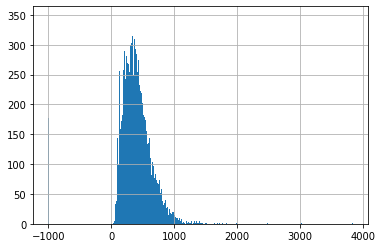

In [232]:
train['Current Loan Expenses (USD)'].hist(bins=1000)

<AxesSubplot:xlabel='Current Loan Expenses (USD)'>

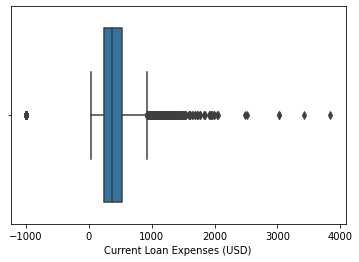

In [233]:
sns.boxplot(x=train['Current Loan Expenses (USD)'])

<AxesSubplot:>

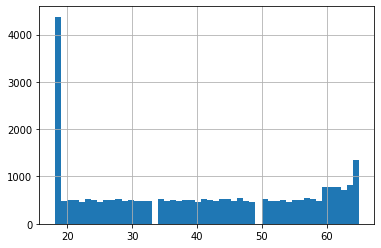

In [237]:
train['Age'].hist(bins=50)

<AxesSubplot:>

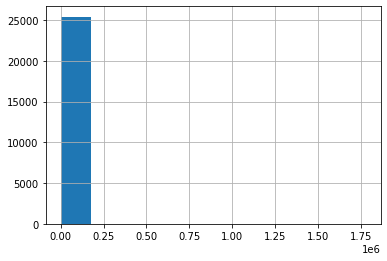

In [238]:
train['Income (USD)'].hist()

<AxesSubplot:xlabel='Income (USD)'>

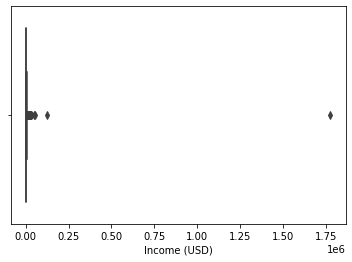

In [240]:
sns.boxplot(x=train['Income (USD)'])

In [ ]:
Since we are not able to get much information from histogram and boxplot so lets get into its descriptive stats 

In [239]:
print('mean:',train['Income (USD)'].mean(),'std:',train['Income (USD)'].std(),'max:',train['Income (USD)'].max(),'min:',train['Income (USD)'].min())

mean: 2630.574417479547 std: 11262.723829935208 max: 1777460.21 min: 377.7


<AxesSubplot:>

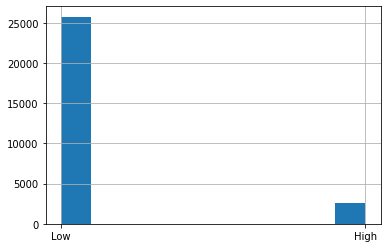

In [241]:
train['Income Stability'].hist()

<AxesSubplot:>

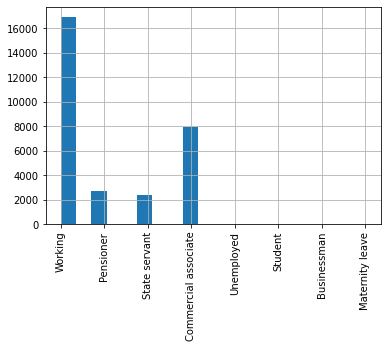

In [242]:
train['Profession'].hist(xrot=90,bins=20)

<AxesSubplot:>

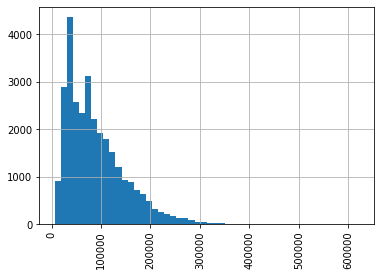

In [243]:
train['Loan Amount Request (USD)'].hist(xrot=90,bins=50)

<AxesSubplot:xlabel='Loan Amount Request (USD)'>

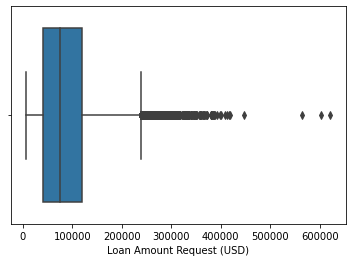

In [244]:
sns.boxplot(x=train['Loan Amount Request (USD)'])

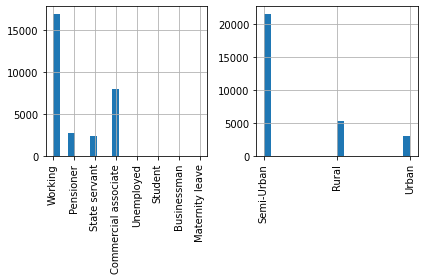

In [245]:
fig, axes = plt.subplots(ncols=2)
train['Profession'].hist(xrot=90,bins=20,ax=axes[0])
train['Location'].hist(xrot=90,bins=20,ax=axes[1])
fig.tight_layout()

<AxesSubplot:>

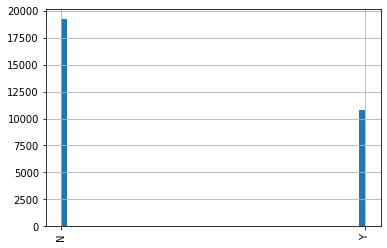

In [246]:
train['Expense Type 1'].hist(xrot=90,bins=50)

<AxesSubplot:>

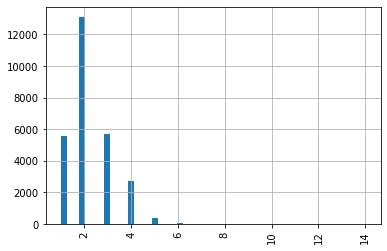

In [247]:
train['Dependents'].hist(xrot=90,bins=50)

<AxesSubplot:>

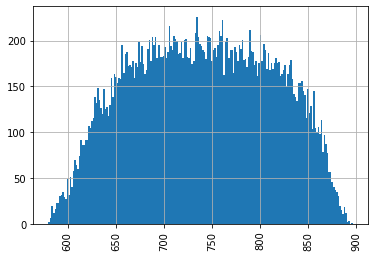

In [248]:
train['Credit Score'].hist(xrot=90,bins=200)

<AxesSubplot:xlabel='Credit Score'>

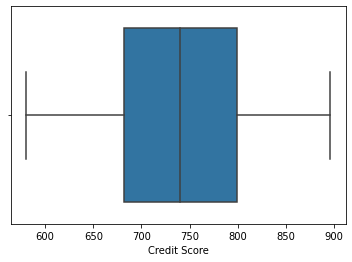

In [249]:
sns.boxplot(x=train['Credit Score'])

<AxesSubplot:>

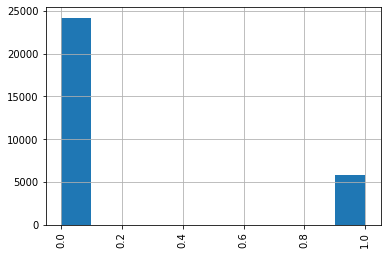

In [250]:
train['No. of Defaults'].hist(xrot=90)

<AxesSubplot:>

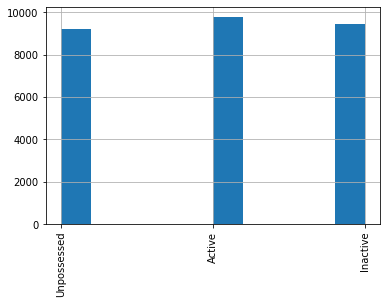

In [251]:
train['Has Active Credit Card'].hist(xrot=90)

<AxesSubplot:>

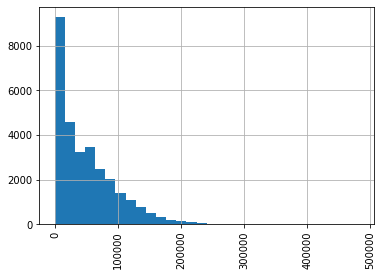

In [252]:
train['Loan Sanction Amount (USD)'].hist(xrot=90,bins=30)

<AxesSubplot:>

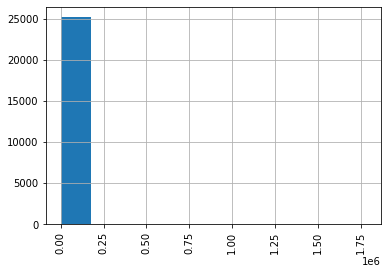

In [253]:
train['Property Age'].hist(xrot=90)

<AxesSubplot:xlabel='Property Age'>

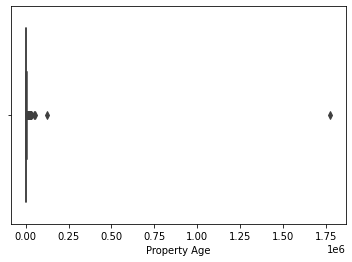

In [254]:
sns.boxplot(x=train['Property Age'])

<AxesSubplot:xlabel='Property Price'>

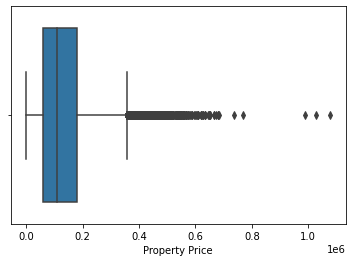

In [255]:
sns.boxplot(x=train['Property Price'])

<AxesSubplot:>

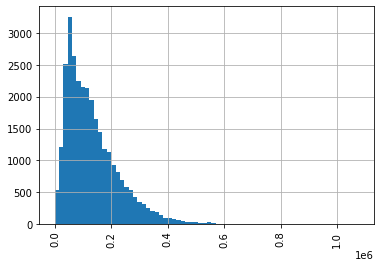

In [256]:
train['Property Price'].hist(xrot=90,bins=70)

<AxesSubplot:xlabel='Loan Amount Request (USD)', ylabel='Loan Sanction Amount (USD)'>

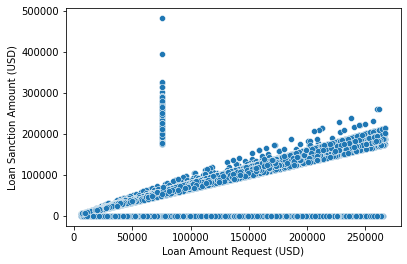

In [306]:
# Scatter plot between Loan Amount Request (USD) and Loan Sanction Amount (USD)

sns.scatterplot(data=train, x="Loan Amount Request (USD)", y="Loan Sanction Amount (USD)")

<AxesSubplot:xlabel='Credit Score', ylabel='Loan Sanction Amount (USD)'>

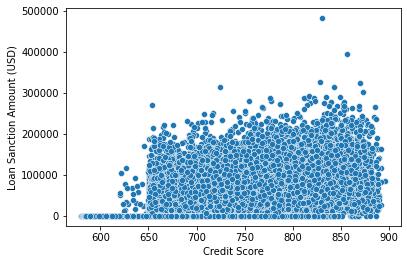

In [307]:
# Scatter plot between Credit Score and Loan Sanction Amount (USD)

sns.scatterplot(data=train, x="Credit Score", y="Loan Sanction Amount (USD)")

<AxesSubplot:xlabel='Property Age', ylabel='Loan Sanction Amount (USD)'>

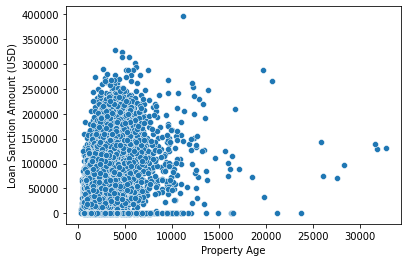

In [308]:
# Scatter plot between Property Age and Loan Sanction Amount (USD)

sns.scatterplot(data=train, x="Property Age", y="Loan Sanction Amount (USD)")

### Lets detect outliers

In [258]:
# Outlier detection using IQR and STD

num_cols=set(train.select_dtypes(include=['int64','float64']).columns)-set(['Loan Sanction Amount (USD)'])
cat_cols = set(train.select_dtypes(include = 'object'))-set(['Customer ID','Name'])
for i in num_cols:
    outlier_mask = out_iqr(train[i], k=2)
    outlier_mask_std = out_std(train[i])
    out_ = train[i][outlier_mask]
    out_sd = train[i][outlier_mask_std]
    if len(out_)!=0 or len(out_sd)!=0:
        
        print(i,':IQR',len(out_),', STD',len(out_sd))
        print('IQR')
        print(out_)
        print('STD')
        print(out_sd)
        print()

No. of Defaults :IQR 5818 , STD 0
IQR
3        1
4        1
5        1
8        1
15       1
        ..
29979    1
29980    1
29983    1
29993    1
29998    1
Name: No. of Defaults, Length: 5818, dtype: int64
STD
Series([], Name: No. of Defaults, dtype: int64)

Co-Applicant :IQR 4484 , STD 168
IQR
2        0
11       0
18       0
20       0
24       0
        ..
29975    0
29983    0
29987    0
29988    0
29989    0
Name: Co-Applicant, Length: 4484, dtype: int64
STD
62      -999
98      -999
150     -999
812     -999
1077    -999
        ... 
29312   -999
29531   -999
29611   -999
29821   -999
29965   -999
Name: Co-Applicant, Length: 168, dtype: int64

Property Price :IQR 388 , STD 405
IQR
87       437535.71
164      519776.20
199      485963.49
215      491475.67
305      445829.27
           ...    
29615    502173.35
29656    426813.98
29658    585264.20
29811    451889.33
29904    498738.14
Name: Property Price, Length: 388, dtype: float64
STD
87       437535.71
164      519776.20


With above statistics it can be seen that using STD method is more benificial as it is removing better outliers like negative numbers instead of true value.
Hence lets use STD outlier and handle them simultaneously. 

In [259]:
# Outlier detection and handling using STD

for i in num_cols:
    outlier_mask_std = out_std(train[i])
    out_sd = train[i][outlier_mask_std]
    if i=='Dependents':
        train[i][outlier_mask_std]=6
    else:
        train[i][outlier_mask_std]=train[i].median()
    if len(out_sd)!=0:
        print(i,': STD',len(out_sd))
        print('STD')
        print(out_sd)
        print()

Co-Applicant : STD 168
STD
62      -999
98      -999
150     -999
812     -999
1077    -999
        ... 
29312   -999
29531   -999
29611   -999
29821   -999
29965   -999
Name: Co-Applicant, Length: 168, dtype: int64

Property Price : STD 405
STD
87       437535.71
164      519776.20
199      485963.49
215      491475.67
285      413976.38
           ...    
29656    426813.98
29658    585264.20
29794    412897.31
29811    451889.33
29904    498738.14
Name: Property Price, Length: 405, dtype: float64

Current Loan Expenses (USD) : STD 362
STD
131      1162.36
303      -999.00
518      -999.00
567      -999.00
657      1172.44
          ...   
29590    1411.88
29637    1355.98
29657    -999.00
29749    -999.00
29784    1322.90
Name: Current Loan Expenses (USD), Length: 362, dtype: float64

Property Age : STD 4
STD
6719      122966.28
15991      48095.16
20965    1777460.21
26619      54653.75
Name: Property Age, dtype: float64

Loan Amount Request (USD) : STD 394
STD
164      281022.99
1

In [260]:
# Prepare combined test and train dataset

train['train']='Y'
test['train']='N'
df = pd.concat([train,test])
df = df.reset_index(drop=True)

In [261]:
df.head()

,Customer ID,Name,Gender,Age,Income (USD),Income Stability,Profession,Type of Employment,Location,Loan Amount Request (USD),Current Loan Expenses (USD),Expense Type 1,Expense Type 2,Dependents,Credit Score,No. of Defaults,Has Active Credit Card,Property ID,Property Age,Property Type,Property Location,Co-Applicant,Property Price,Loan Sanction Amount (USD),train
0,C-36995,Frederica Shealy,F,56,1933.05,Low,Working,Sales staff,Semi-Urban,72809.58,241.08,N,N,3.0,809.44,0,NaN,746,1933.05,4,Rural,1,119933.46,54607.18,Y
1,C-33999,America Calderone,M,32,4952.91,Low,Working,NaN,Semi-Urban,46837.47,495.81,N,Y,1.0,780.40,0,Unpossessed,608,4952.91,2,Rural,1,54791.0,37469.98,Y
2,C-3770,Rosetta Verne,F,65,988.19,High,Pensioner,NaN,Semi-Urban,45593.04,171.95,N,Y,1.0,833.15,0,Unpossessed,546,988.19,2,Urban,0,72440.58,36474.43,Y
3,C-26480,Zoe Chitty,F,65,NaN,High,Pensioner,NaN,Rural,80057.92,298.54,N,Y,2.0,832.70,1,Unpossessed,890,NaN,2,Semi-Urban,1,121441.51,56040.54,Y
4,C-23459,Afton Venema,F,31,2614.77,Low,Working,High skill tech staff,Semi-Urban,113858.89,491.41,N,Y,NaN,745.55,1,Active,715,2614.77,4,Semi-Urban,1,208567.91,74008.28,Y


In [262]:
# Add discreatised features

df['Age_cat'] = pd.qcut(df['Age'],6)
cat_cols.add('Age_cat')

# df['Loan_Amount_Request_cat'] = pd.qcut(df['Loan Amount Request (USD)'],6)
# cat_cols.add('Loan_Amount_Request_cat')

In [263]:
# Column names of missing value's columns

miss_cols = df.columns[df.isnull().any()]
miss_idx = []
for i in miss_cols:
    miss_idx.append((np.where(df[i].isnull())[0],i))


In [264]:
# Encoding

df = lab_encoder(df,cat_cols)
df.head()

,Customer ID,Name,Gender,Age,Income (USD),Income Stability,Profession,Type of Employment,Location,Loan Amount Request (USD),Current Loan Expenses (USD),Expense Type 1,Expense Type 2,Dependents,Credit Score,No. of Defaults,Has Active Credit Card,Property ID,Property Age,Property Type,Property Location,Co-Applicant,Property Price,Loan Sanction Amount (USD),train,Age_cat
0,C-36995,Frederica Shealy,0,56,1933.05,1,7,14,1,72809.58,241.08,0,0,3.0,809.44,0,3,746,1933.05,4,0,1,119933.46,54607.18,Y,4
1,C-33999,America Calderone,1,32,4952.91,1,7,18,1,46837.47,495.81,0,1,1.0,780.40,0,2,608,4952.91,2,0,1,54791.0,37469.98,Y,2
2,C-3770,Rosetta Verne,0,65,988.19,0,3,18,1,45593.04,171.95,0,1,1.0,833.15,0,2,546,988.19,2,2,0,72440.58,36474.43,Y,5
3,C-26480,Zoe Chitty,0,65,NaN,0,3,18,0,80057.92,298.54,0,1,2.0,832.70,1,2,890,NaN,2,1,1,121441.51,56040.54,Y,5
4,C-23459,Afton Venema,0,31,2614.77,1,7,6,1,113858.89,491.41,0,1,NaN,745.55,1,0,715,2614.77,4,1,1,208567.91,74008.28,Y,2


## Handling data noise and missing values calculation 

In [265]:
# Replacing missing values with nan after encoding 

for i in miss_idx:
    df[i[1]].iloc[i[0]]=np.nan


In [266]:
# Genrating for missing values of dependents based on age category

mode_=[]
for i in df['Age_cat'].unique():
    mode_.append(df[df['Age_cat']==i]['Dependents'].mode()[0])
mode_

[2.0, 2.0, 2.0, 2.0, 2.0, 2.0]

 With above finding it can be said that in every age mostly dependents are 2 only. So taking the mode for missing values which is 2 only

In [268]:
df['Dependents']=df['Dependents'].fillna(df['Dependents'].mode()[0])

In [267]:
# Genrating for missing values of Gender based on maximum frequency

df['Gender']=df['Gender'].fillna(df['Gender'].mode()[0])

In [269]:
# Handling Co-Applicant's noise

df['Co-Applicant']=df['Co-Applicant'].replace('?', df['Co-Applicant'].mode()[0])
df['Co-Applicant']=df['Co-Applicant'].astype('int64')

In [270]:
# Handling Property Price's noise

idx=np.where(df['Property Price']=='?')
idxs=set(range(df.shape[0])) - set(idx[0])
pp_mean = df.iloc[list(idxs)]['Property Price'].astype('float64').mean()
df['Property Price']=df['Property Price'].replace('?', str(pp_mean))
df['Property Price']=df['Property Price'].astype('float64')
df['Property Price']=df['Property Price'].replace(-999.0, pp_mean)

In [ ]:
# Handling Loan Sanction Amount (USD)'s noise

df['Loan Sanction Amount (USD)']=df['Loan Sanction Amount (USD)'].replace(-999.0, np.nan)

In [271]:
# Genrating missing values for Property Location

idx=np.where(df['Property Location'].isnull())
unique_ids = df['Property ID'].unique()
mode_pl = df['Property Location'].mode()[0] 
for i in idx[0]:
    id_ = df['Property ID'].iloc[i]
    if id_ in unique_ids:
        df['Property Location'].iloc[i] = df[df['Property ID']==id_]['Property Location'].mode()[0]
    else:
        df['Property Location'].iloc[i] = mode_pl
    

In [272]:
# Genrating missing values for Current Loan Expenses (USD)

idx=np.where(df['Current Loan Expenses (USD)'].isnull())
idxs=set(range(df.shape[0])) - set(idx[0])
pp_mean = df.iloc[list(idxs)]['Current Loan Expenses (USD)'].astype('float64').mean()
df['Current Loan Expenses (USD)']=df['Current Loan Expenses (USD)'].replace(np.nan, str(pp_mean))
df['Current Loan Expenses (USD)']=df['Current Loan Expenses (USD)'].astype('float64')

In [275]:
# Genrating missing values for Income (USD)

col = 'Income (USD)'
df_miss_na = df.drop(['Customer ID','Name','Loan Sanction Amount (USD)','train'],axis=1)
df_miss = df_miss_na.dropna()
idx_inc = np.where(df[col].isnull())

y_m = df_miss[col]
X_m = df_miss.drop([col],axis=1)

model_mreg = CatBoostRegressor(iterations=5000)    
model_mreg.fit(X_m,y_m,verbose=100)
y_train_pred = model_mreg.predict(X_m)

ym_pred = model_mreg.predict(df_miss_na.iloc[idx_inc])
for i in range(0,len(ym_pred)):
    df.at[idx_inc[0][i],col] = ym_pred[i]
    
print(col,': ',r2_score(y_m, y_train_pred))

Learning rate set to 0.020965
0:	learn: 1370.0172666	total: 5.73ms	remaining: 28.6s
100:	learn: 323.1210118	total: 520ms	remaining: 25.2s
200:	learn: 232.7895159	total: 1.03s	remaining: 24.7s
300:	learn: 206.5959161	total: 1.54s	remaining: 24s
400:	learn: 172.8729662	total: 2.05s	remaining: 23.6s
500:	learn: 143.2054388	total: 2.59s	remaining: 23.2s
600:	learn: 125.1134626	total: 3.12s	remaining: 22.8s
700:	learn: 112.0972739	total: 3.65s	remaining: 22.4s
800:	learn: 101.0305186	total: 4.25s	remaining: 22.3s
900:	learn: 91.8847360	total: 4.93s	remaining: 22.5s
1000:	learn: 83.3368798	total: 5.52s	remaining: 22s
1100:	learn: 76.7568090	total: 6.12s	remaining: 21.7s
1200:	learn: 70.7118812	total: 6.67s	remaining: 21.1s
1300:	learn: 64.9955414	total: 7.2s	remaining: 20.5s
1400:	learn: 58.5794997	total: 7.71s	remaining: 19.8s
1500:	learn: 53.8382201	total: 8.23s	remaining: 19.2s
1600:	learn: 50.3195049	total: 8.75s	remaining: 18.6s
1700:	learn: 47.9986859	total: 9.27s	remaining: 18s
1800:	

In [276]:
# Genrating missing values for Type of Employment

col = 'Type of Employment'
df_miss_na = df.drop(['Customer ID','Name','Loan Sanction Amount (USD)','train'],axis=1)
df_miss = df_miss_na.dropna()
idx_toe = np.where(df[col].isnull())

y_m = df_miss[col]
X_m = df_miss.drop([col],axis=1)

model_mreg = CatBoostClassifier(loss_function='MultiClass', custom_metric=['AUC'])
model_mreg.fit(X_m,y_m,verbose=100)
#y_train_pred = model_mreg.predict(X_m)

# Missing value pred
ym_pred = model_mreg.predict(df_miss_na.iloc[idx_toe])
for i in range(0,len(ym_pred)):
    df.at[idx_toe[0][i],col] = int(ym_pred[i])
    
# Train score    
train_pred = model_mreg.predict_proba(X_m)
print(col,': ',roc_auc_score(y_m, train_pred,multi_class='ovo'))

Learning rate set to 0.094014
0:	learn: 2.7502831	total: 94.2ms	remaining: 1m 34s
100:	learn: 2.0121560	total: 9.49s	remaining: 1m 24s
200:	learn: 1.9310091	total: 18.6s	remaining: 1m 13s
300:	learn: 1.8529639	total: 27.6s	remaining: 1m 4s
400:	learn: 1.7818947	total: 36.6s	remaining: 54.7s
500:	learn: 1.7092555	total: 46s	remaining: 45.8s
600:	learn: 1.6444741	total: 55.1s	remaining: 36.6s
700:	learn: 1.5782434	total: 1m 4s	remaining: 27.4s
800:	learn: 1.5168850	total: 1m 13s	remaining: 18.3s
900:	learn: 1.4575574	total: 1m 22s	remaining: 9.1s
999:	learn: 1.4035316	total: 1m 32s	remaining: 0us
Type of Employment :  0.9620958965064401


In [277]:
# Genrating missing values for Income Stability

col = 'Income Stability'
df_miss_na = df.drop(['Customer ID','Name','Loan Sanction Amount (USD)','train'],axis=1)
df_miss = df_miss_na.dropna()
idx_is = np.where(df[col].isnull())

y_m = df_miss[col]
X_m = df_miss.drop([col],axis=1)

model_mreg = CatBoostClassifier(custom_metric=['AUC'])
model_mreg.fit(X_m,y_m,verbose=100)
#y_train_pred = model_mreg.predict(X_m)

# Missing value pred
ym_pred = model_mreg.predict(df_miss_na.iloc[idx_is])
for i in range(0,len(ym_pred)):
    df.at[idx_is[0][i],col] = int(ym_pred[i])
    
# Train score    
train_pred = model_mreg.predict_proba(X_m)[:,1]
print(col,': ',roc_auc_score(y_m, train_pred))

Learning rate set to 0.048939
0:	learn: 0.5200608	total: 16.5ms	remaining: 16.5s
100:	learn: 0.0008269	total: 1.29s	remaining: 11.5s
200:	learn: 0.0006107	total: 2.32s	remaining: 9.22s
300:	learn: 0.0006041	total: 3.33s	remaining: 7.73s
400:	learn: 0.0006040	total: 4.26s	remaining: 6.37s
500:	learn: 0.0006039	total: 5.24s	remaining: 5.22s
600:	learn: 0.0006039	total: 6.21s	remaining: 4.12s
700:	learn: 0.0006039	total: 7.14s	remaining: 3.05s
800:	learn: 0.0006039	total: 8.08s	remaining: 2.01s
900:	learn: 0.0006039	total: 9.01s	remaining: 990ms
999:	learn: 0.0006039	total: 9.93s	remaining: 0us
Income Stability :  0.999999991593552


In [278]:
# Genrating missing values for Has Active Credit Card

col = 'Has Active Credit Card'
df_miss_na = df.drop(['Customer ID','Name','Loan Sanction Amount (USD)','train'],axis=1)
df_miss = df_miss_na.dropna()
idx_ac = np.where(df[col].isnull())

y_m = df_miss[col]
X_m = df_miss.drop([col],axis=1)

model_mreg = CatBoostClassifier(iterations=5000,loss_function='MultiClass',custom_metric=['AUC'])
model_mreg.fit(X_m,y_m,verbose=100)
#y_train_pred = model_mreg.predict(X_m)

# Missing value pred
ym_pred = model_mreg.predict(df_miss_na.iloc[idx_ac])
for i in range(0,len(ym_pred)):
    df.at[idx_ac[0][i],col] = int(ym_pred[i])
    
# Train score    
train_pred = model_mreg.predict_proba(X_m)
print(col,': ',roc_auc_score(y_m, train_pred,multi_class='ovo'))

Learning rate set to 0.024517
0:	learn: 1.0985158	total: 22.5ms	remaining: 1m 52s
100:	learn: 1.0918549	total: 2.21s	remaining: 1m 46s
200:	learn: 1.0865133	total: 4.12s	remaining: 1m 38s
300:	learn: 1.0811074	total: 6.11s	remaining: 1m 35s
400:	learn: 1.0760936	total: 8.04s	remaining: 1m 32s
500:	learn: 1.0710139	total: 9.94s	remaining: 1m 29s
600:	learn: 1.0656560	total: 11.8s	remaining: 1m 26s
700:	learn: 1.0605930	total: 13.7s	remaining: 1m 24s
800:	learn: 1.0556890	total: 15.7s	remaining: 1m 22s
900:	learn: 1.0509222	total: 17.6s	remaining: 1m 20s
1000:	learn: 1.0462454	total: 19.5s	remaining: 1m 18s
1100:	learn: 1.0415781	total: 21.5s	remaining: 1m 15s
1200:	learn: 1.0371619	total: 23.4s	remaining: 1m 13s
1300:	learn: 1.0325692	total: 25.3s	remaining: 1m 11s
1400:	learn: 1.0282100	total: 27.3s	remaining: 1m 10s
1500:	learn: 1.0238061	total: 29.2s	remaining: 1m 8s
1600:	learn: 1.0195661	total: 31.2s	remaining: 1m 6s
1700:	learn: 1.0156393	total: 33.4s	remaining: 1m 4s
1800:	learn:

In [279]:
# Genrating missing values for Credit Score

col = 'Credit Score'
df_miss_na = df.drop(['Customer ID','Name','Loan Sanction Amount (USD)','train'],axis=1)
df_miss = df_miss_na.dropna()
idx_inc = np.where(df[col].isnull())

y_m = df_miss[col]
X_m = df_miss.drop([col],axis=1)

model_mreg = CatBoostRegressor(iterations=10000)    
model_mreg.fit(X_m,y_m,verbose=100)
y_train_pred = model_mreg.predict(X_m)

ym_pred = model_mreg.predict(df_miss_na.iloc[idx_inc])
for i in range(0,len(ym_pred)):
    df.at[idx_inc[0][i],col] = ym_pred[i]
    
print(col,': ',r2_score(y_m, y_train_pred))

Learning rate set to 0.013212
0:	learn: 72.0857045	total: 8.22ms	remaining: 1m 22s
100:	learn: 65.6771552	total: 702ms	remaining: 1m 8s
200:	learn: 64.2625421	total: 1.41s	remaining: 1m 8s
300:	learn: 63.6771329	total: 2.1s	remaining: 1m 7s
400:	learn: 63.3334151	total: 2.8s	remaining: 1m 7s
500:	learn: 63.1007513	total: 3.5s	remaining: 1m 6s
600:	learn: 62.8964006	total: 4.21s	remaining: 1m 5s
700:	learn: 62.7185958	total: 4.98s	remaining: 1m 6s
800:	learn: 62.5487793	total: 5.67s	remaining: 1m 5s
900:	learn: 62.3849139	total: 6.36s	remaining: 1m 4s
1000:	learn: 62.2339704	total: 7.02s	remaining: 1m 3s
1100:	learn: 62.0981234	total: 7.68s	remaining: 1m 2s
1200:	learn: 61.9662780	total: 8.35s	remaining: 1m 1s
1300:	learn: 61.8397158	total: 9.02s	remaining: 1m
1400:	learn: 61.7153586	total: 9.69s	remaining: 59.5s
1500:	learn: 61.5790481	total: 10.4s	remaining: 58.7s
1600:	learn: 61.4510960	total: 11s	remaining: 57.9s
1700:	learn: 61.3302958	total: 11.7s	remaining: 57.1s
1800:	learn: 61.

In [280]:
# Genrating missing values for Property Age

col = 'Property Age'
df_miss_na = df.drop(['Customer ID','Name','Loan Sanction Amount (USD)','train'],axis=1)
df_miss = df_miss_na.dropna()
idx_inc = np.where(df[col].isnull())

y_m = df_miss[col]
X_m = df_miss.drop([col],axis=1)

model_mreg = CatBoostRegressor(iterations=5000)    
model_mreg.fit(X_m,y_m,verbose=100)
y_train_pred = model_mreg.predict(X_m)

ym_pred = model_mreg.predict(df_miss_na.iloc[idx_inc])
for i in range(0,len(ym_pred)):
    df.at[idx_inc[0][i],col] = ym_pred[i]
    
print(col,': ',r2_score(y_m, y_train_pred))

Learning rate set to 0.022551
0:	learn: 1418.2406217	total: 8.15ms	remaining: 40.8s
100:	learn: 339.0880973	total: 717ms	remaining: 34.8s
200:	learn: 260.4284457	total: 1.4s	remaining: 33.3s
300:	learn: 226.3883880	total: 2.06s	remaining: 32.2s
400:	learn: 194.3420682	total: 2.72s	remaining: 31.2s
500:	learn: 169.3046535	total: 3.4s	remaining: 30.5s
600:	learn: 151.2250439	total: 4.07s	remaining: 29.8s
700:	learn: 136.2661005	total: 4.74s	remaining: 29.1s
800:	learn: 120.0715293	total: 5.42s	remaining: 28.4s
900:	learn: 110.5553688	total: 6.09s	remaining: 27.7s
1000:	learn: 102.7059778	total: 6.78s	remaining: 27.1s
1100:	learn: 94.1723037	total: 7.47s	remaining: 26.4s
1200:	learn: 85.6188886	total: 8.16s	remaining: 25.8s
1300:	learn: 75.6883463	total: 8.87s	remaining: 25.2s
1400:	learn: 69.1731287	total: 9.62s	remaining: 24.7s
1500:	learn: 64.6219779	total: 10.3s	remaining: 24s
1600:	learn: 60.7485841	total: 11s	remaining: 23.4s
1700:	learn: 57.3733791	total: 11.7s	remaining: 22.7s
180

## Model Training

In [290]:
# Train and test split

train_df = df[df['train']=='Y']
test_df = df[df['train']=='N']

In [291]:
# Train preparation

train_df = train_df[train_df['Loan Sanction Amount (USD)'].notna()]
train_df = train_df.drop(['Customer ID','Name','train'],axis=1)
train_df.shape

(29322, 23)

In [292]:
# Test preparation 

cust_id = test_df['Customer ID']
test_df = test_df.drop(['Customer ID','Name','Loan Sanction Amount (USD)','train'],axis=1)
test_df.shape

(20000, 22)

In [293]:
# Split X,Y

Y = train_df['Loan Sanction Amount (USD)']
X = train_df.drop(['Loan Sanction Amount (USD)'],axis=1)

In [294]:
# Base model

oof_pred_reg  = np.zeros((len(train_df)))
#y_pred_reg   = np.zeros((len(df_test.shape[0])))
n_splits  = 5
test_rmse_score = []
test_r2_score = []

kf=KFold(n_splits=n_splits,shuffle=True,random_state=2062021)

for i,(train_idx,val_idx) in enumerate(kf.split(X,Y)):  

    
    X_train, y_train = X.iloc[train_idx,:], Y.iloc[train_idx]

    X_val, y_val = X.iloc[val_idx, :], Y.iloc[val_idx]


    print('\nFold: {}\n'.format(i+1))

    modellgb_reg = lgb.LGBMRegressor(iterations=5000, learning_rate=0.02)    
    modellgb_reg.fit(X_train,y_train,eval_set=(X_val, y_val),verbose=100)
    testpred1 = modellgb_reg.predict(X_val)
    
    test_r2_score.append(r2_score(y_val, testpred1))
    print("Test r2_score for model 1: %.4f"%(r2_score(y_val, testpred1)))
    
    test_rmse_score.append(mean_squared_error(y_val, testpred1,squared=False))
    print("Test mean_squared_error for model 1: %.4f"%(mean_squared_error(y_val, testpred1,squared=False)))
    
    val_pred   = testpred1
    
    print('\n')



Fold: 1

[LightGBM] [Warning] Unknown parameter: iterations
[100]	valid_0's l2: 5.45697e+08
Test r2_score for model 1: 0.7661
Test mean_squared_error for model 1: 23360.1520



Fold: 2

[LightGBM] [Warning] Unknown parameter: iterations
[100]	valid_0's l2: 5.33414e+08
Test r2_score for model 1: 0.7691
Test mean_squared_error for model 1: 23095.7673



Fold: 3

[LightGBM] [Warning] Unknown parameter: iterations
[100]	valid_0's l2: 5.20092e+08
Test r2_score for model 1: 0.7792
Test mean_squared_error for model 1: 22805.5242



Fold: 4

[LightGBM] [Warning] Unknown parameter: iterations
[100]	valid_0's l2: 5.1519e+08
Test r2_score for model 1: 0.7889
Test mean_squared_error for model 1: 22697.8071



Fold: 5

[LightGBM] [Warning] Unknown parameter: iterations
[100]	valid_0's l2: 5.07722e+08
Test r2_score for model 1: 0.7670
Test mean_squared_error for model 1: 22532.6803




In [295]:
# Base model's prediction

y_pred_lgb = modellgb_reg.predict(X)
y_pred_lgb_test = modellgb_reg.predict(test_df)

# Adding column to train and test

train_df['y_pred_lgb'] = y_pred_lgb
test_df['y_pred_lgb'] = y_pred_lgb_test

In [297]:
# Meta Model

Y = train_df['Loan Sanction Amount (USD)']
X = train_df.drop(['Loan Sanction Amount (USD)'],axis=1)

oof_pred_reg  = np.zeros((len(train_df)))
n_splits  = 5
test_rmse_score = []
test_r2_score = []

kf=KFold(n_splits=n_splits,shuffle=True,random_state=2062021)

for i,(train_idx,val_idx) in enumerate(kf.split(X,Y)):  

    
    X_train, y_train = X.iloc[train_idx,:], Y.iloc[train_idx]

    X_val, y_val = X.iloc[val_idx, :], Y.iloc[val_idx]


    print('\nFold: {}\n'.format(i+1))

    model1_reg = CatBoostRegressor(iterations=2500, learning_rate=0.02)    
    model1_reg.fit(X_train,y_train,eval_set=(X_val, y_val),verbose=100)
    testpred1 = model1_reg.predict(X_val)
    
    test_r2_score.append(r2_score(y_val, testpred1))
    print("Test r2_score for model 1: %.4f"%(r2_score(y_val, testpred1)))
    
    test_rmse_score.append(mean_squared_error(y_val, testpred1,squared=False))
    print("Test mean_squared_error for model 1: %.4f"%(mean_squared_error(y_val, testpred1,squared=False)))
    
    val_pred   = testpred1
    
    print('\n')



Fold: 1

0:	learn: 47450.0633995	test: 47563.4844897	best: 47563.4844897 (0)	total: 6.94ms	remaining: 17.4s
100:	learn: 22131.4688356	test: 22813.5823197	best: 22813.5823197 (100)	total: 553ms	remaining: 13.1s
200:	learn: 20866.4551512	test: 21768.3732080	best: 21768.3732080 (200)	total: 1.11s	remaining: 12.7s
300:	learn: 20520.5595319	test: 21680.7410114	best: 21679.9881961 (298)	total: 1.66s	remaining: 12.1s
400:	learn: 20227.8004045	test: 21687.3386815	best: 21676.7666827 (343)	total: 2.2s	remaining: 11.5s
500:	learn: 19970.0221528	test: 21700.1790462	best: 21676.7666827 (343)	total: 2.75s	remaining: 11s
600:	learn: 19686.7169296	test: 21745.0518102	best: 21676.7666827 (343)	total: 3.28s	remaining: 10.4s
700:	learn: 19458.7102272	test: 21776.0270934	best: 21676.7666827 (343)	total: 3.8s	remaining: 9.76s
800:	learn: 19233.4087852	test: 21774.6925011	best: 21676.7666827 (343)	total: 4.33s	remaining: 9.19s
900:	learn: 19027.4614178	test: 21800.5794924	best: 21676.7666827 (343)	total: 

In [302]:
# Final prediction

y_pred = model1_reg.predict(test_df)
for i in range(0,len(y_pred)):
    if y_pred[i]<0:
        y_pred[i] = -y_pred[i]

In [304]:
# Feature importance

model1_reg.get_feature_importance(prettified=True)

,Feature Id,Importances
0,y_pred_lgb,73.956848
1,Loan Amount Request (USD),9.584745
2,Property Price,3.417983
3,Credit Score,2.459580
4,Current Loan Expenses (USD),1.524984
5,Property Age,1.352011
6,Income (USD),1.228177
7,Property ID,0.976086
8,Age,0.812851
9,Dependents,0.703883


In [303]:
# Submission dataframe

sub = pd.DataFrame({'Customer ID':cust_id,'Loan Sanction Amount (USD)':y_pred}) 
sub.to_csv("cat_reg_v19.csv", index = False)
sub

,Customer ID,Loan Sanction Amount (USD)
30000,C-26247,89738.577461
30001,C-35067,68357.022507
30002,C-34590,1142.600454
30003,C-16668,49642.222286
30004,C-12196,67942.633508
...,...,...
49995,C-9076,95537.674446
49996,C-17587,28205.424634
49997,C-46479,1489.030875
49998,C-3099,72703.088488


### Unused commented code

Below are the some of the technique which were tried but did not find out to be useful. 

In [ ]:
# temp = df.groupby(['Loan_Amount_Request_cat']).agg({'Loan Sanction Amount (USD)':['mean']})
# temp.columns = ['_'.join(x) for x in temp.columns]
# df = pd.merge(df,temp,on=['Loan_Amount_Request_cat'],how='left')

# df = df.drop(['Loan Sanction Amount (USD)_mean'],axis=1)
# imputer = KNNImputer(n_neighbors= 5)
# imputed = imputer.fit_transform(df_knn)
# df_imputed = pd.DataFrame(imputed, columns = df_knn.columns)
# df_imputed[['Customer ID','Name','Loan Sanction Amount (USD)','train']]=df[['Customer ID','Name','Loan Sanction Amount (USD)','train']].values
# df_imputed = pickle_load('/kaggle/input/pickle-knn/df_imputed')
# pickle_save('df_imputed',df_imputed)

# comb = combinations(cat_cols, 3) 
# for i in list(comb):  
#     df[f'{i[0]}_{i[1]}_{i[2]}']=df[i[0]].astype(str)+'_'+df[i[1]].astype(str)+'_'+df[i[2]].astype(str)
#     frequency_encoding(f'{i[0]}_{i[1]}_{i[2]}',f'{i[0]}_{i[1]}_{i[2]}',df)
   
# df['cs_score_cat'] = (df['Credit Score']>750).astype(int)